# Probabilistic Neural Networks Demo

## Advanced Machine Learning

### Andrew H. Fagg (andrewhfagg@gmail.com)

Key versions:
- python=3.12
- tensorflow=2.18.0
- tf_keras=2.18.0


In [1]:
# NOTE: it is really important to import the version of keras that
#  is compatible with TF Probability

%reload_ext autoreload
%autoreload 2

import sys

import argparse
import copy
import pickle
import random
import matplotlib.pyplot as plt 
import numpy as np


import tensorflow as tf

# THIS IS REALLY IMPORTANT
import tf_keras as keras
from tf_keras.models import Sequential
import tensorflow_probability as tfp

# Sub namespaces that are useful later
# Tensorflow Distributions
tfd = tfp.distributions
# Probability Layers 
tfpl = tfp.layers

from tf_keras.layers import Layer, Concatenate
from tf_keras.layers import Dense, BatchNormalization, Dropout
from tf_keras import Input, Model
from matplotlib import colors
from tf_keras.utils import plot_model

#################################################################
# Default plotting parameters
FIGURESIZE=(8,6)
FONTSIZE=14

plt.rcParams['figure.figsize'] = FIGURESIZE
plt.rcParams['font.size'] = FONTSIZE

plt.rcParams['xtick.labelsize'] = FONTSIZE
plt.rcParams['ytick.labelsize'] = FONTSIZE

#################################################################

2025-03-27 15:31:44.749240: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-27 15:31:44.762710: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743107504.781227   11694 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743107504.787006   11694 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-27 15:31:44.805097: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
# Turn off the GPU
tf.config.set_visible_devices([], 'GPU')

2025-03-27 15:31:48.551302: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2025-03-27 15:31:48.551376: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:137] retrieving CUDA diagnostic information for host: aegir
2025-03-27 15:31:48.551383: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:144] hostname: aegir
2025-03-27 15:31:48.551494: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:168] libcuda reported version is: 550.120.0
2025-03-27 15:31:48.551515: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:172] kernel reported version is: 550.120.0
2025-03-27 15:31:48.551521: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:259] kernel version seems to match DSO: 550.120.0


## Create Data Set

In [3]:
# ~Gaussian density
def gauss(t, mu, sigma):
    return np.exp(-np.square((t-mu)/sigma))

In [4]:
# Regular sampling
t = np.arange(0, 10, .01)

# Create noisy values that are periodic in t
y = np.cos(t) + t/3
noise = np.random.normal(0, .1*t, y.shape[0])
y = y + noise

# Create a 2nd set of noisy values that have two modes centered at t=3
g = gauss(t, 3, 1)
sign = np.random.choice([1,-1], size = y.shape[0])
y2 = y+3*sign*g

Text(0, 0.5, 'y')

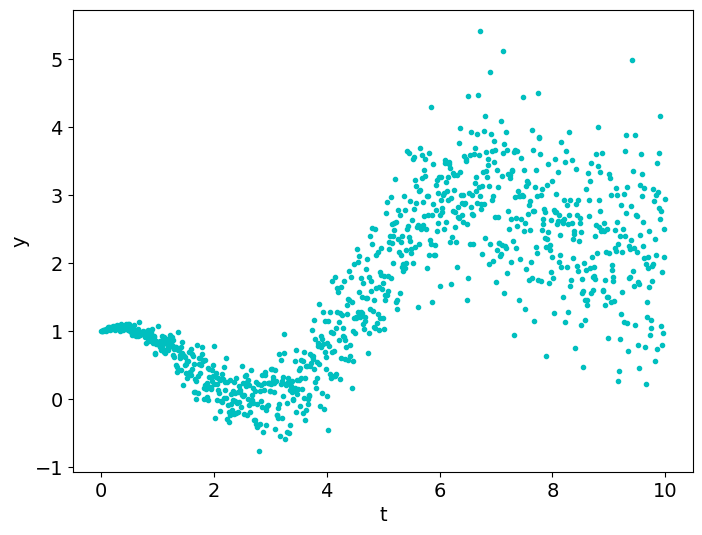

In [5]:
plt.plot(t, y, 'c.')
plt.xlabel('t')
plt.ylabel('y')

(array([ 1.,  5.,  9., 23., 28., 42., 53., 44., 36., 43., 50., 88., 50.,
        22., 24., 22., 34., 26., 26., 36., 39., 31., 40., 37., 44., 30.,
        22., 22., 26., 19.,  9.,  7.,  3.,  1.,  4.,  0.,  1.,  0.,  2.,
         0.,  1.]),
 array([-7.55944088e-01, -6.05308007e-01, -4.54671925e-01, -3.04035843e-01,
        -1.53399762e-01, -2.76367994e-03,  1.47872402e-01,  2.98508483e-01,
         4.49144565e-01,  5.99780647e-01,  7.50416728e-01,  9.01052810e-01,
         1.05168889e+00,  1.20232497e+00,  1.35296106e+00,  1.50359714e+00,
         1.65423322e+00,  1.80486930e+00,  1.95550538e+00,  2.10614146e+00,
         2.25677754e+00,  2.40741363e+00,  2.55804971e+00,  2.70868579e+00,
         2.85932187e+00,  3.00995795e+00,  3.16059403e+00,  3.31123012e+00,
         3.46186620e+00,  3.61250228e+00,  3.76313836e+00,  3.91377444e+00,
         4.06441052e+00,  4.21504661e+00,  4.36568269e+00,  4.51631877e+00,
         4.66695485e+00,  4.81759093e+00,  4.96822701e+00,  5.11886310e+00,
 

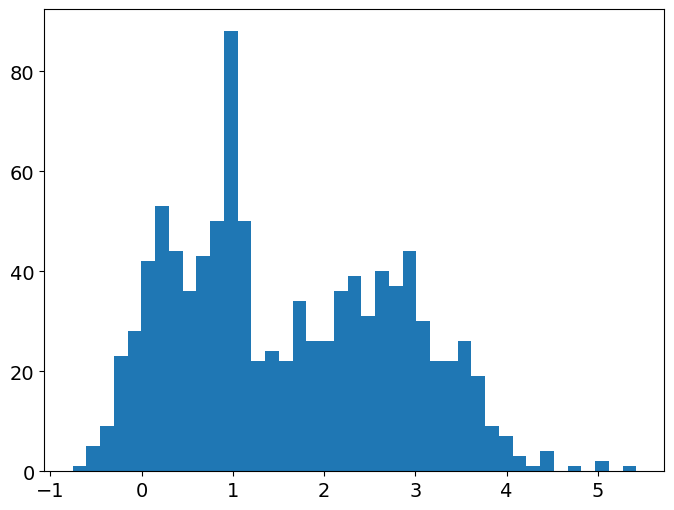

In [6]:
plt.hist(y, bins=41)

(-1.0, 6.0)

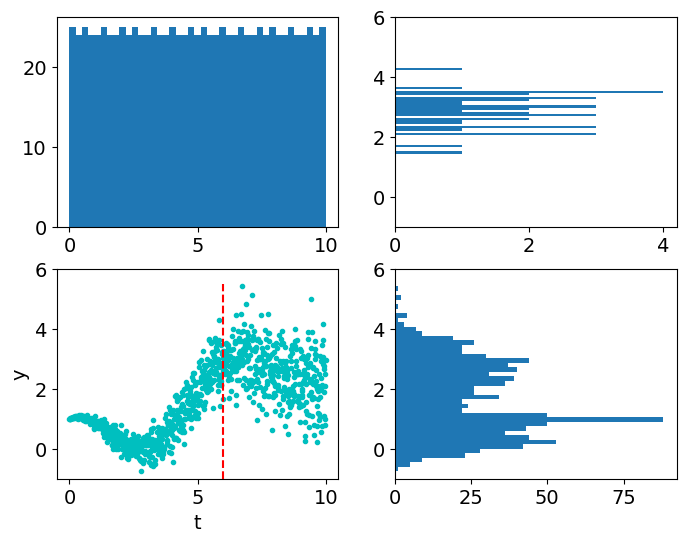

In [7]:
fig, axes = plt.subplots(2, 2)  

t_example = 6
epsilon = 0.2

axes[1,0].plot(t, y, 'c.')
axes[1,0].plot([t_example,t_example], [-1,5.5], 'r--')
axes[1,0].set_ylim([-1,6])

axes[1,0].set_xlabel('t')
axes[1,0].set_ylabel('y')

axes[1,1].hist(y, bins=41, orientation='horizontal')
axes[1,1].set_ylim([-1,6])
axes[0,0].hist(t, bins=41)

# Pick ys around t=6
ys = [y_sample for t_sample, y_sample in zip(t,y) 
      if (t_sample > t_example-epsilon) and (t_sample < t_example+epsilon)]
axes[0,1].hist(ys, bins=41, orientation='horizontal')
axes[0,1].set_ylim([-1,6])

## Divergent Distribution

Text(0, 0.5, 'y2')

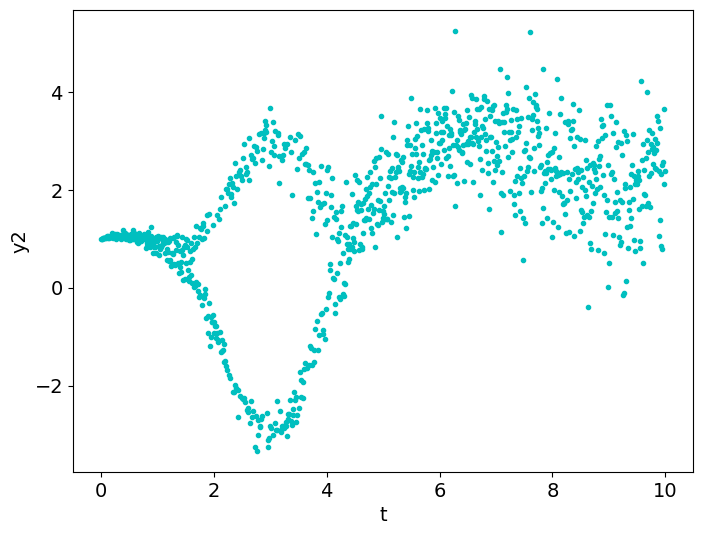

In [14]:
plt.plot(t,y2, 'c.')
plt.xlabel('t')
plt.ylabel('y2')

## Create network

Support code

In [11]:
def fully_connected_stack(n_inputs:int, 
                          n_hidden:int, 
                          n_output:int, 
                          activation:str='elu', 
                          activation_out:str=None,
                          lrate:float=0.001, 
                          dropout:float=None, 
                          dropout_input:float=None, 
                          kernel_regularizer_L2:float=None, 
                          kernel_regularizer_L1:float=None):

    '''
    General network building code that creates a stack of Dense layers.
    The output of the stack is a list of output Keras Tensors, each with its own activation function.
    If the output activation function is 'positive', then the output is elu()+1.1
    
    :param n_inputs: Number of input units
    :param n_hidden: List of hidden layer sizes
    :param n_output: List of the number of output units for each output Tensor
    :param activation: Activation function for hidden layers
    :param activation_out: List of the activation functions for each output Tensor
    :param lrate: Learning rate
    :param dropout: Dropout probability for hidden layers
    :param dropout_input: Dropout probability for input layer
    :param kernel_regularizer_L2: L2 regularization param
    :param kernel_regularizer_L1: L1 regularization param
    :return: (input tensor, list of output tensors)
    '''
    
    if dropout is not None:
        print("DENSE: DROPOUT %f"%dropout)

    # L2 or L1 regularization?
    kernel_regularizer = None
    if kernel_regularizer_L2 is not None:
        print("DENSE: L2 Regularization %f"%kernel_regularizer)
        kernel_regularizer=tf.keras.regularizers.l2(kernel_regularizer)
    elif kernel_regularizer_L1 is not None:
        # Only us L1 if specified *and* L2 is not active
        print("DENSE: L1 Regularization %f"%kernel_regularizer_L1)
        kernel_regularizer=tf.keras.regularizers.l1(kernel_regularizer_L1)

    # Input layer
    input_tensor = tensor = Input(shape=(n_inputs,))
    
    # Dropout input features?
    if dropout_input is not None:
        tensor = Dropout(rate=dropout_input, name="dropout_input")(tensor)
            
    # Loop over hidden layers
    for i, n in enumerate(n_hidden):             
        tensor = Dense(n, use_bias=True, name="hidden_%02d"%(i), activation=activation,
                 kernel_regularizer=kernel_regularizer)(tensor)
        
        if dropout is not None:
            tensor = Dropout(rate=dropout, name="dropout_%02d"%(i))(tensor)
    
    # Output layers
    outputs = []
    for i, (n, act) in enumerate(zip(n_output, activation_out)):
        o = Dense(n, use_bias=True, name="output%d"%i, activation=act)(tensor)
        outputs.append(o)

    return input_tensor, outputs
    


In [12]:
# Build a simple network
input_tensor, output_tensors  = fully_connected_stack(n_inputs=1, 
                                                   n_hidden=[100, 50, 20], 
                                                   n_output=[1],
                                                   activation='elu',
                                                   activation_out=['linear'],
                                                   dropout=None)

# Optimizer
opt = keras.optimizers.Adam(learning_rate=0.001, amsgrad=False)

model = Model(inputs=input_tensor, outputs=output_tensors)
model.compile(loss='mse', optimizer=opt)


In [13]:
print(model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 hidden_00 (Dense)           (None, 100)               200       
                                                                 
 hidden_01 (Dense)           (None, 50)                5050      
                                                                 
 hidden_02 (Dense)           (None, 20)                1020      
                                                                 
 output0 (Dense)             (None, 1)                 21        
                                                                 
Total params: 6291 (24.57 KB)
Trainable params: 6291 (24.57 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [18]:
# Train the model
history = model.fit(t, y, epochs=200, verbose=0)

I0000 00:00:1742935071.929747  397943 service.cc:148] XLA service 0x774fd800c4f0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742935071.929802  397943 service.cc:156]   StreamExecutor device (0): Host, Default Version
2025-03-25 15:37:52.031506: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-03-25 15:37:52.031572: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1742935072.326452  397941 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [19]:
y_hat = model.predict(t)

32/32 [==============================] - 0s 1ms/step


Text(0, 0.5, 'y')

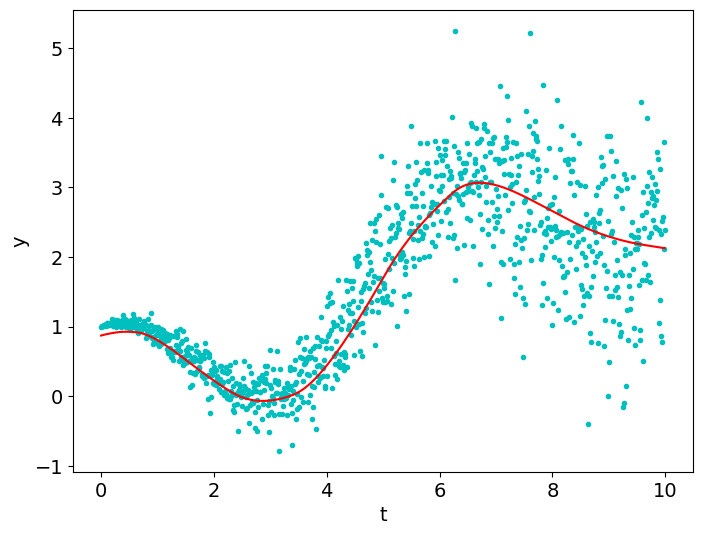

In [20]:
plt.plot(t, y, 'c.')
plt.plot(t, y_hat, 'r')
plt.xlabel('t')
plt.ylabel('y')

## Probabilistic Outputs

Next model: given the input (t), our model will generate the parameters for 
a Normal distribution.

We will take an inner/outer model approach:
- The inner model takes t as an input and produces mu and sigma as output.  
- Outer model takes t as an input and produces a TF Probability Distribution (yes, it is not a Keras Tensor!).  We will use this outer model for training using a custom loss function that returns the negative log likelihood of the desired output



In [16]:
# Custom loss function

@tf.function
def mdn_loss(y, dist):
    '''
    Compute negative log likelihood of the desired output
    
    :param y: True value (from the training set)
    :param dist: A TF Probability Distribution
    :return: The negative likelihood of each true value
    '''
    return -dist.log_prob(y)


In [17]:
# Input (t) is 1-dimensional
n_inputs = 1

# Output (y) is a 1-dimensional value
d_output = 1


# Inner model.  The outputs will be mu and sigma, respectively

# Compute the number of output units
n_outputs = tfpl.IndependentNormal.params_size(event_shape=d_output)

# Main model stack
input_tensor, output_tensors  = fully_connected_stack(n_inputs=n_inputs, 
                                                      n_hidden=[100, 50, 20], 
                                                      n_output=[n_outputs],
                                                      activation='elu',
                                                      activation_out=['linear'],
                                                      dropout=None)

model_inner = Model(inputs=input_tensor, outputs=output_tensors)

#######################
# Outer model
# Key: do not mix Keras Tensors between these two models, but
#  we can use the inner model as a layer

tensor = input_tensor2 = Input(shape=(n_inputs,))
output_tensors2 = model_inner(tensor)

# Combine outputs into one tensor
#output_tensors2 = Concatenate(axis=-1)(output_tensors2)

# This layer takes a Keras Tensor as input and returns a TF Probability Distribution
#  It also handles the constraint that std must be positive, so model_inner does not 
#  need to enforce this
output2 = tfpl.IndependentNormal(event_shape=d_output)(output_tensors2)

model_outer = Model(inputs=input_tensor2, outputs=output2)

# Optimizer
opt = keras.optimizers.Adam(learning_rate=0.001, amsgrad=False)

# We don't have to use a built-in loss function; instead we provide our own
model_outer.compile(optimizer=opt, loss=mdn_loss)

print(model_outer.summary())


Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1)]               0         
                                                                 
 model_4 (Functional)        (None, 2)                 6312      
                                                                 
 independent_normal_1 (Inde  ((None, 1),               0         
 pendentNormal)               (None, 1))                         
                                                                 
Total params: 6312 (24.66 KB)
Trainable params: 6312 (24.66 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


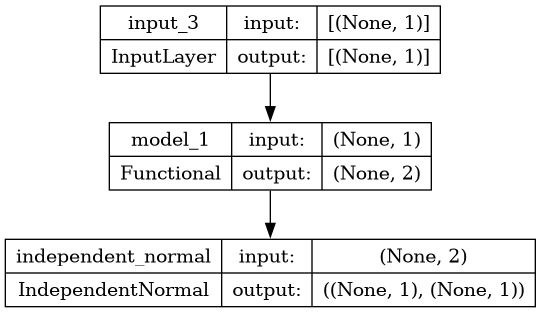

In [23]:
plot_model(model_outer, to_file='pnn_outer.png', show_shapes=True, show_layer_names=True)

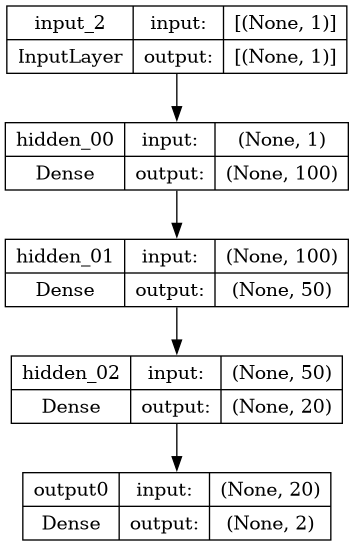

In [24]:
plot_model(model_inner, to_file='pnn_inner.png', show_shapes=True, show_layer_names=True)

In [25]:
# Train the model
history2 = model_outer.fit(x=t, y=y, epochs=200, verbose=0)

In [27]:
# Extract the details of the distribution for each value of t

# Approach #1: use the distributions generated by the outer model
dists = model_outer(t)
mu = dists.parameters['distribution'].mean()
std = dists.parameters['distribution'].stddev()

In [ ]:
# Approach #2 (alternative to the above cell): use the outputs from the inner model

params = model_inner.predict(t)
mu = params[:,0]
# The distribution includes the softplus nonlinearity to ensure that 
#  std is not negative.  We have to do it explicitly here
std = tf.nn.softplus(params[:,1])

Text(0, 0.5, 'y')

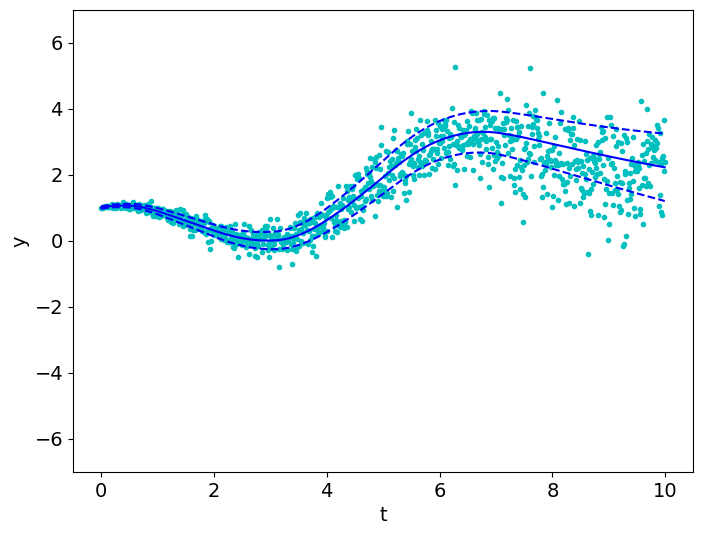

In [28]:
# Show data and the distribution
plt.plot(t, y, 'c.')
plt.plot(t, mu, 'b-')
plt.plot(t, mu+std, 'b--')
plt.plot(t, mu-std, 'b--')
plt.ylim([-7,7])
plt.xlabel('t')
plt.ylabel('y')

## Fit to the Divergent Data Set

In [18]:
history3 = model_outer.fit(x=t, y=y2, epochs=200, verbose=0)

In [19]:
# Using Approach #1 
dists = model_outer(t)
mu3 = dists.parameters['distribution'].mean()
std3 = dists.parameters['distribution'].stddev()

# Approach #2
#params3 = model_inner.predict(t)
#mu3 = params3[:,0]
#std3 = tf.nn.softplus(params3[:,1])

In [25]:
# Sample for a specific input
t_value = 3

query = np.ones((20,)) * t_value
samples3 = model_outer.predict(query)

1/1 [==============================] - 0s 21ms/step


Text(0, 0.5, 'y')

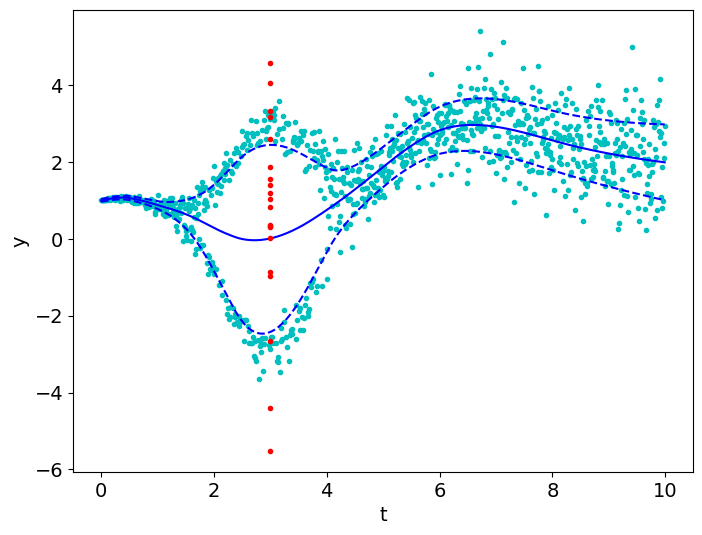

In [26]:
# Show the data and the distribution
plt.plot(t, y2, 'c.')
plt.plot(t, mu3, 'b')
plt.plot(t, mu3+std3, 'b--')
plt.plot(t, mu3-std3, 'b--')
plt.plot(query, samples3, 'r.')
plt.xlabel('t')
plt.ylabel('y')

## Mixture of Gaussians

- Inner model: compute the parameters of your mixture distribution.  For 2 Gaussians, we need 2 means, 2 standard deviations, and 2 weights.  The ultimate non-linearity for the weights is softmax(); our inner model will produce the values *before* the softmax (these are commonly referred to as 'logits')
- Outer model: takes these distribution parameters as input into the Mixture Distribution Layer

In [27]:
# Input is 1-dimensional
n_inputs = 1

# Output is a 1-dimensional value
d_output = 1

# Number of Gaussians
n_gaussians = 2

# Inner model.  The outputs will be mu, sigma, and logits, respectively

# Compute the number of output units for the inner model
n_outputs = tfpl.MixtureNormal.params_size(num_components=n_gaussians, 
                                           event_shape=d_output)

# Main model stack
input_tensor, output_tensors  = fully_connected_stack(n_inputs=n_inputs, 
                                                      n_hidden=[1000,100, 50, 20], 
                                                      n_output=[n_outputs],
                                                      activation='elu',
                                                      activation_out=['linear'],
                                                      dropout=None)

model_inner4 = Model(inputs=input_tensor, outputs=output_tensors)

#######################
# Outer model
# Key: do not mix Keras Tensors between these two models, but
#  we can use the inner model as a layer in the Outer model

tensor = input_tensor2 = Input(shape=(n_inputs,))
output_tensors2 = model_inner4(tensor)

# This layer takes a Keras Tensor as input and returns a TF Probability Distribution
#  It also handles the constraint that std must be positive
#  NOTE: this only workks right now when using Keras 2
output2 = tfpl.MixtureNormal(num_components=n_gaussians, 
                             event_shape=d_output)(output_tensors2)

model_outer4 = Model(inputs=input_tensor2, outputs=output2)

# Optimizer
opt4 = keras.optimizers.Adam(learning_rate=0.0001, amsgrad=False)

# We don't have to use a built-in loss function.  Instead, we use the
#   one defined above
model_outer4.compile(optimizer=opt4, loss=mdn_loss)

print(model_outer4.summary())


Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 1)]               0         
                                                                 
 model_6 (Functional)        (None, 6)                 108296    
                                                                 
 mixture_normal (MixtureNor  ((None, 1),               0         
 mal)                         (None, 1))                         
                                                                 
Total params: 108296 (423.03 KB)
Trainable params: 108296 (423.03 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


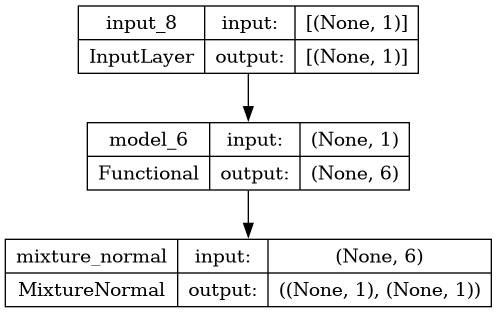

In [28]:
plot_model(model_outer4, to_file='pnn_mixture_outer.png', show_shapes=True, show_layer_names=True)

In [ ]:
plot_model(model_inner4, to_file='pnn_mixture_outer.png', show_shapes=True, show_layer_names=True)

In [29]:
# Need a lot more epochs to train this model
history4 = model_outer4.fit(x=t, y=y2, epochs=1000, verbose=0)

Text(0.5, 0, 'epoch')

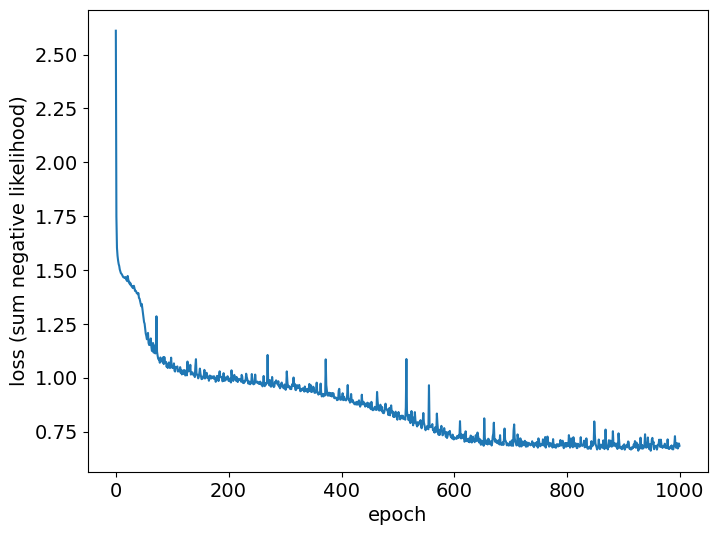

In [30]:
# Show loss
plt.plot(history4.history['loss'])
plt.ylabel('loss (sum negative likelihood)')
plt.xlabel('epoch')

In [31]:
# Query the model: Approach #1

# The process is different than with a single Normal distribution

# One parameterized dist for every element in t
dists4 = model_outer4(t)

# Extract the logits and convert into weights
logits4 = dists4.tensor_distribution.mixture_distribution.logits.numpy() 
prob4 = tf.nn.softmax(logits4)

# Means
mu4 = dists4.tensor_distribution.components_distribution.tensor_distribution.mean().numpy() 

# Standard deviations (note that the PDF ensures that these stds are non-negative (it uses a softplus() nonlinearity
std4 = dists4.tensor_distribution.components_distribution.tensor_distribution.stddev().numpy()


2025-03-27 15:45:25.725661: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT32 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


In [38]:
# Extract a set of samples for a instant input
t_value = 3
query4 = np.ones((20,)) * t_value

# Do the sampling
samples4 = model_outer4.predict(query4)

1/1 [==============================] - 0s 21ms/step


Text(0.5, 0, 't')

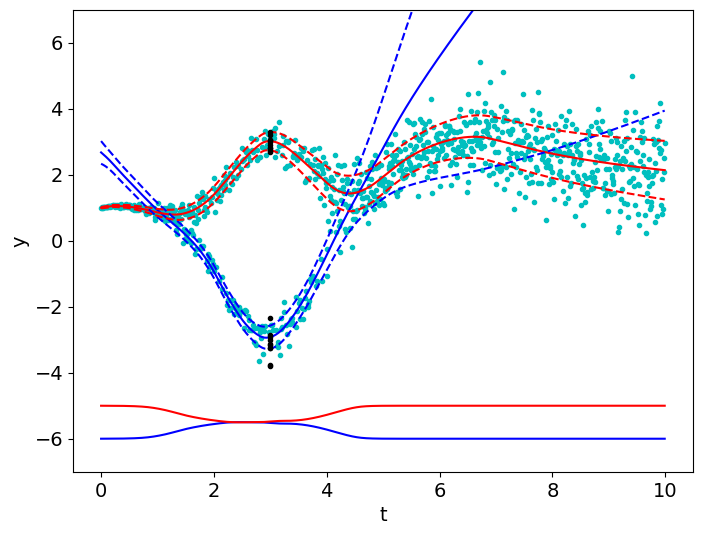

In [39]:
# Show the data and the distribution
plt.plot(t, y2, 'c.')

# Two means
plt.plot(t,mu4[:,0], 'b')
plt.plot(t, mu4[:,1], 'r')

# +/- one standard deviation
plt.plot(t, mu4[:,0]+std4[:,0], 'b--')
plt.plot(t, mu4[:,0]-std4[:,0], 'b--')

plt.plot(t, mu4[:,1]+std4[:,1], 'r--')
plt.plot(t, mu4[:,1]-std4[:,1], 'r--')

# Show the weights
plt.plot(t, prob4[:,0]-6, 'b')
plt.plot(t, prob4[:,1]-6, 'r')

# Sample distribution
plt.plot(query4, samples4, 'k.')

plt.ylim([-7,7])
plt.ylabel('y')
plt.xlabel('t')

# Probabilistic Neural Networks Demo, Example II
## A More General Approach (maybe)

## Advanced Machine Learning

### Andrew H. Fagg (andrewhfagg@gmail.com)

The following approach does not require a Keras model to return a distribution.  On the one hand, the approach should work for a larger range of Keras implementations.  However, it is a little more wonky because:
1. The 'desired output' is an input to the training model
2. If we want to ask questions after training about the distributions, we have to construct them ourselves, rather than the outer model producing them


Structure:
- We are using a single Normal distribution
- The inner model translates some input (t in this case)  into two outputs: mu and sigma for each input element
- The outer model is used for training:
   1. Inputs: t and the true observations (y)
   2. Outputs: mu and sigma for each input element (for some reason, this version of Keras does not like having no output)
   3. The model uses model.add_loss() directly, and does not declare a loss at the model.compile() step
  


In [36]:

def mdn_cost(parameter_tensors, y):
    '''
    Custom loss function
    
    Use this through model.add_loss()
    Key here: this is evaluated using TF Tensors (as opposed to Keras Tensors)
        The difference is that TF Tensors actually have values
    :param parameter_tensors: List of TF tensors: one for mean, and the other for standard deviation
    :param y: TF Tensor containing the true value that the likelihood is measured for
    :return: Scalar mean negative log likelihood
    
    '''

    # Extract the individual parameter tensors
    mu, sigma = parameter_tensors

    # Construct the distributions (one for each mu/sigma)
    dist = tfp.distributions.Normal(loc=mu, scale=sigma)

    # Mean log likelihood
    return tf.reduce_mean(-dist.log_prob(y))



In [ ]:
# Input is 1-dimensional
n_inputs = 1

# Output is a 1-dimensional value
d_output = 1

# Build a simple network
# Note that we have to explicitly force std to be positive
input_tensor, output_tensors  = fully_connected_stack(n_inputs=1, 
                                                   n_hidden=[100, 50, 20], 
                                                   n_output=[d_output, d_output],
                                                   activation='elu',
                                                   activation_out=['linear', 'softplus'],
                                                   dropout=None)


model_inner5 = Model(inputs=input_tensor, outputs=output_tensors)

####################################

# Wrapper network has two inputs and two outputs
#  A bit of a hack: the true values are inputs

tensor = input_tensor5 = Input(shape=(n_inputs,))
y_real = Input(shape=(n_inputs,))

output_tensors5 = model_inner5(tensor)

model_outer5 = Model(inputs=[input_tensor5, y_real], outputs=output_tensors5)

# We can add any loss we want to our cost function
model_outer5.add_loss(mdn_cost(output_tensors5, y_real))

# Default optimizer
opt = keras.optimizers.Adam(learning_rate=0.001, amsgrad=False)

# We don't have to use a built-in loss function
model_outer5.compile(optimizer=opt)

print(model_outer5.summary())


In [ ]:
# Train the model
history5 = model_outer5.fit(x=[t,y], epochs=200, verbose=0)

In [ ]:
mu5, std5 = model_inner5.predict(t)

In [ ]:
# Sample for a specific input
t_value = 7

n_samples = 20
query5 = np.ones((n_samples,)) * t_value
mu_sample5, sigma_sample5 = model_inner5.predict([t_value])
samples5 =  tfp.distributions.Normal(loc=mu_sample5, scale=sigma_sample5).sample([n_samples])

In [ ]:
# Show the data and the distribution
plt.plot(t, y, 'c.')
plt.plot(t, mu5, 'b')
plt.plot(t, mu5+std5, 'b--')
plt.plot(t, mu5-std5, 'b--')
plt.plot(query5, np.squeeze(samples5), 'r.')
plt.xlabel('t')
plt.ylabel('y')